### Building Logistic Regression Model

A manager thinks that players preference should be respected when it comes to playing position. It ensures that the player will stay longer with the club and will be productive. So he wants to know whether a player likes to play in the forward, midfield, defense or combinations of these positions. A logistic regerssion model capbable of predicting the prefered positon of a player will help the manager filter out suitable player based on the situation of his club. For example, if there are enough midfield players in my team the manager may like to take players who like to play forward only. If the team is balanced, taking players with combined preferences might be preferable.

In [1]:
import pandas as pd
import statistics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# the first column can be used as index of the dataframe
fifa18 = pd.read_csv("../../../Data & Script/fifa-18-demo-player-dataset/fifa18.csv", index_col=0)
def fix(x):
    # evaluate sum
    if('+' in str(x).strip()):
        calc = x.split('+')
        return int(calc[0]) + int(calc[1])
    # evaluate subtraction
    elif('-' in str(x).strip()):
        calc = x.split('-')
        return int(calc[0]) + int(calc[1])
    # convert to integer if string contains a valid number
    elif str(x).strip().isdigit():
        return int(x)
    # return as it is, for example null values
    else:
         return x
for column in fifa18.iloc[:,11:74]:
    fifa18[column] = fifa18[column].apply(fix)
def convert(v):
        if('M' in str(v)):
            return float(v[1:-1]) * 1e6
        elif('K' in str(v)):
            return float(v[1:-1]) * 1e3  
        elif('€0' in str(v)):
            return float(v[1:])
        else:
            return v

fifa18['Value'] = fifa18['Value'].apply(convert)
fifa18['Wage'] = fifa18['Wage'].apply(convert)
fifa18.head(5)

,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,95500000.0,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,105000000.0,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,Neymar,25,https://cdn.sofifa.org/48/18/players/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,94,Paris Saint-Germain,https://cdn.sofifa.org/24/18/teams/73.png,123000000.0,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,L. Suárez,30,https://cdn.sofifa.org/48/18/players/176580.png,Uruguay,https://cdn.sofifa.org/flags/60.png,92,92,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,97000000.0,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,M. Neuer,31,https://cdn.sofifa.org/48/18/players/167495.png,Germany,https://cdn.sofifa.org/flags/21.png,92,92,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,61000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Player Positions

Forward Positions
- LS, ST RS, LW, LF, CF, RF, RW

Midfield Positions
- LAM, CAM, RAM, LM, LCM, RCM, CM, RM, LDM, CDM, RDM

Defender Positions

- LB, LWB, LCB, CB, RCB, RB, RWB

Goal Keeper

- GK

In [2]:
# dropping rows based on condition
somedf = pd.DataFrame({"A":[1,2,3], "B":[5,4,7], "C":["GK","RM","CB"]})
somedf.drop(somedf[somedf.C.str.contains("GK")].index, inplace=True)
somedf

,A,B,C
1,2,4,RM
2,3,7,CB


In [3]:
# drop by index(remove Goal keepers)
fifa18.drop(fifa18[fifa18['Preferred Positions'].str.contains('GK')].index, inplace=True)

In [4]:
forward = {'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW'}
# All the midfield positions end with an M
midfield = {'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'RCM','CM', 'RM', 'LDM', 'CDM', 'RDM'}
defense = {'LB', 'LWB', 'LCB', 'CB', 'RCB', 'RB', 'RWB'}

assert(len(forward) + len(midfield) + len(defense) == 26)

In [5]:
# create three features
fifa18['forward_rating'] = fifa18[list(forward)].mean(axis=1)
fifa18['midfield_rating'] = fifa18[list(midfield)].mean(axis=1)
fifa18['defense_rating'] = fifa18[list(defense)].mean(axis=1)

I coded a function below which returns

- 0 GK position
- 1 forward only
- 2 midfield only
- 3 midfield and forward
- 4 defense only
- 5 defense and forward
- 6 defense and midfiled
- 7 defense, midfield and forward

I represented the  cases in a truth table
    <table align = left >
    <tr>
    <td><b>Defense</b></td>
    <td><b>Midfield</b></td>
    <td><b>Forward</b></td>
    <td><b>To Decimal</b></td>
    <tr/>
    <tr><td>0</td><td>0</td><td>0</td><td>0</td></tr>
    <tr><td>0</td><td>0</td><td>1</td><td>1</td></tr>
    <tr><td>0</td><td>1</td><td>0</td><td>2</td></tr>
    <tr><td>0</td><td>1</td><td>1</td><td>3</td></tr>
    <tr><td>1</td><td>0</td><td>0</td><td>4</td></tr>
    <tr><td>1</td><td>0</td><td>1</td><td>5</td></tr>
    <tr><td>1</td><td>1</td><td>0</td><td>6</td></tr>
    <tr><td>1</td><td>1</td><td>1</td><td>7</td></tr>
   </table>

In [6]:
def create_position_code(pos_str):    
    d = len(defense.intersection(pos_str.split())) > 0
    m = len(midfield.intersection(pos_str.split())) > 0 
    f = len(forward.intersection(pos_str.split())) > 0
    return int("".join([str(int(d)), str(int(m)), str(int(f))]), 2)    

fifa18["preference_code"] = fifa18['Preferred Positions'].apply(create_position_code)

In [7]:
fifa18[["preference_code","Preferred Positions"]].sample(10)

,preference_code,Preferred Positions
7843,2,CAM RM
3379,1,ST
8750,6,CM RB CDM
5113,2,LM RM
14532,2,RM
6712,6,LM LB
9173,4,LB
3651,2,CM CAM
801,2,CM CDM
8561,6,LWB CM CAM LM


In [8]:
fifa18.preference_code.value_counts()

2    5357
4    4846
1    2541
3    1587
6    1532
7      45
5      44
Name: preference_code, dtype: int64

In [9]:
# select only numeric types
fifa18 = fifa18.select_dtypes(include=[np.number])
fifa18.columns

Index(['Age', 'Overall', 'Potential', 'Value', 'Wage', 'Special',
       'Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control',
       'Composure', 'Crossing', 'Curve', 'Dribbling', 'Finishing',
       'Free kick accuracy', 'GK diving', 'GK handling', 'GK kicking',
       'GK positioning', 'GK reflexes', 'Heading accuracy', 'Interceptions',
       'Jumping', 'Long passing', 'Long shots', 'Marking', 'Penalties',
       'Positioning', 'Reactions', 'Short passing', 'Shot power',
       'Sliding tackle', 'Sprint speed', 'Stamina', 'Standing tackle',
       'Strength', 'Vision', 'Volleys', 'CAM', 'CB', 'CDM', 'CF', 'CM', 'ID',
       'LAM', 'LB', 'LCB', 'LCM', 'LDM', 'LF', 'LM', 'LS', 'LW', 'LWB', 'RAM',
       'RB', 'RCB', 'RCM', 'RDM', 'RF', 'RM', 'RS', 'RW', 'RWB', 'ST',
       'forward_rating', 'midfield_rating', 'defense_rating',
       'preference_code'],
      dtype='object')

In [10]:
X = fifa18.iloc[:,:-1]
y = fifa18.preference_code

In [11]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
selector_one = SelectKBest(f_classif , k=5)
selector_one.fit(X, y)
print(X.columns[selector_one.get_support(indices=True)])

Index(['Finishing', 'Interceptions', 'Marking', 'Sliding tackle',
       'Standing tackle'],
      dtype='object')


In [12]:
selector_two = SelectKBest(mutual_info_classif, k=5)
selector_two.fit(X, y)
print(X.columns[selector_two.get_support(indices=True)])

Index(['Finishing', 'Interceptions', 'Marking', 'Sliding tackle',
       'Standing tackle'],
      dtype='object')


In [13]:
# # logistic regression RFE
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import StratifiedKFold
# from sklearn.feature_selection import RFECV 
# # The "accuracy" scoring is proportional to the number of correct classifications
# selector_three = RFECV(estimator= LogisticRegression(n_jobs=-1), step=1, cv=StratifiedKFold(10), n_jobs=-1,
#               scoring='accuracy', verbose=True)
# selector_three.fit(X, y)
# print(X.columns[selector_three.get_support(indices=True)])

# print("Optimal number of features : %d" % selector_three.n_features_)
# print(X.columns[selector_three.get_support(indices=True)])
# print("score: ", selector_three.score(X, y))
# # Plot number of features VS. cross-validation scores
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(selector_three.grid_scores_) + 1), selector_three.grid_scores_)
# plt.show()

In [14]:
# from sklearn.svm import SVC
# from sklearn.model_selection import StratifiedKFold
# from sklearn.feature_selection import RFECV 
# # The "accuracy" scoring is proportional to the number of correct classifications
# selector_three = RFECV(estimator= SVC(kernel="linear", tol=0.01), step=1, cv=StratifiedKFold(10),
#               n_jobs=-1, scoring='accuracy')
# selector_three.fit(X, y)
# print(X.columns[selector_three.get_support(indices=True)])

# print("Optimal number of features : %d" % selector_three.n_features_)
# print(X.columns[selector_three.get_support(indices=True)])
# print("score: ", selector_three.score(X, y))
# # Plot number of features VS. cross-validation scores
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(selector_three.grid_scores_) + 1), selector_three.grid_scores_)
# plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Optimal number of features : 8
Index(['Crossing', 'Finishing', 'Heading accuracy', 'Long passing', 'Marking',
       'Sliding tackle', 'Standing tackle', 'Vision'],
      dtype='object')
0.9820085255767302


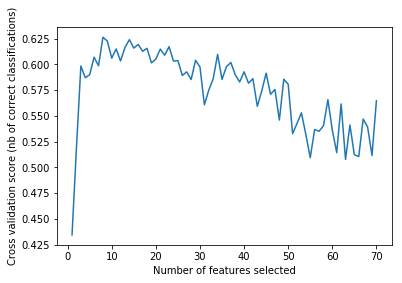

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
# The "accuracy" scoring is proportional to the number of correct
# classifications
selector_four = RFECV(RandomForestClassifier(n_jobs=-1), scoring='accuracy')
selector_four.fit(X, y)
print("Optimal number of features : %d" % selector_four.n_features_)
print(X.columns[selector_four.get_support(indices=True)])
print(selector_four.score(X,y))
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector_four.grid_scores_) + 1), selector_four.grid_scores_)
plt.show()

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20, shuffle=True)

In [17]:
from sklearn.linear_model import LogisticRegression
X_train_t = selector_two.transform(X_train)
X_test_t = selector_two.transform(X_test)
# no regularization(becasue the inverse regularization is big)
modelA = LogisticRegression(C=1e20, solver='newton-cg', multi_class='multinomial')
modelA.fit(X_train_t, y_train)

# Display.
#print('Coefficients')
#print(modelA.coef_)
#print(modelA.intercept_)
yhat = modelA.predict(X_train_t)

print('\n Accuracy')
print(pd.crosstab(y_train, yhat, rownames=['True'], colnames=['Predicted']))

print('\n Percentage accuracy')
print("training: ", modelA.score(X_train_t, y_train))
print("testing: ", modelA.score(X_test_t, y_test))


 Accuracy
Predicted     1     2   3     4  6
True                              
1          1698   300  48     0  0
2           415  3277  33   559  2
3           684   568  36     3  0
4             0   427   0  3397  3
5             2    31   0     5  0
6             2   568   0   666  1
7             1    28   0     6  1

 Percentage accuracy
training:  0.6589608964814669
testing:  0.6772171732999059


In [18]:
# Vanilla Logistic Regression
from sklearn.linear_model import LogisticRegression
X_train_t = selector_four.transform(X_train)
X_test_t = selector_four.transform(X_test)
# no regularization(becasue the inverse regularization is big)
modelA = LogisticRegression(C=1e20, solver='newton-cg', multi_class='multinomial')
modelA.fit(X_train_t, y_train)

# Display.
#print('Coefficients')
#print(modelA.coef_)
#print(modelA.intercept_)
yhat = modelA.predict(X_train_t)

print('\n Accuracy')
print(pd.crosstab(y_train, yhat, rownames=['True'], colnames=['Predicted']))

print('\n Percentage accuracy')
print("training: ", modelA.score(X_train_t, y_train))
print("testing: ", modelA.score(X_test_t, y_test))


 Accuracy
Predicted     1     2    3     4  5    6
True                                    
1          1709   172  158     1  0    6
2            97  3699  217   229  0   44
3           418   584  282     3  0    4
4             0   162    0  3539  0  126
5             4    10    0    15  1    8
6             1   467    3   641  0  125
7             2    22    1     9  0    2

 Percentage accuracy
training:  0.7330930177885746
testing:  0.7389533061736133


In [19]:
# L2 regularized
from sklearn.linear_model import LogisticRegression
X_train_t = selector_four.transform(X_train)
X_test_t = selector_four.transform(X_test)
# 
modelB = LogisticRegression(penalty='l2', solver='newton-cg', C=0.1, multi_class='multinomial')
modelB.fit(X_train_t, y_train)

# Display.
#print('Coefficients')
#print(modelB.coef_)
#print(modelB.intercept_)
yhat = modelB.predict(X_train_t)

print('\n Accuracy')
print(pd.crosstab(y_train, yhat, rownames=['True'], colnames=['Predicted']))

print('\n Percentage accuracy')
print("training: ", modelB.score(X_train_t, y_train))
print("testing: ", modelB.score(X_test_t, y_test))


 Accuracy
Predicted     1     2    3     4  5    6
True                                    
1          1710   172  157     1  0    6
2            97  3699  217   229  0   44
3           418   584  282     3  0    4
4             0   162    0  3539  0  126
5             4    10    0    15  1    8
6             1   467    3   641  0  125
7             2    22    1     9  0    2

 Percentage accuracy
training:  0.7331713815531699
testing:  0.7389533061736133


In [20]:
# L1 regulararized
from sklearn.linear_model import LogisticRegression
X_train_t = selector_four.transform(X_train)
X_test_t = selector_four.transform(X_test)

modelC = LogisticRegression(penalty='l1', solver='liblinear', C=1e1, multi_class='ovr')
modelC.fit(X_train_t, y_train)

# Display.
print('Coefficients')
print(modelC.coef_)
print(modelC.intercept_)
yhat = modelC.predict(X_train_t)

print('\n Accuracy')
print(pd.crosstab(y_train, yhat, rownames=['True'], colnames=['Predicted']))

print('\n Percentage accuracy')
print("training: ", modelC.score(X_train_t, y_train))
print("testing: ", modelC.score(X_test_t, y_test))

Coefficients
[[-0.0441314   0.12536514  0.04393537 -0.06689365 -0.03607373 -0.01632517
  -0.01992354 -0.02334469]
 [-0.06253716 -0.00315393 -0.10414676  0.11736109 -0.02669643 -0.0006627
   0.02204636  0.07641953]
 [ 0.03366142  0.05141034 -0.02438004  0.0011619  -0.01325667 -0.02418003
  -0.01223568  0.00722692]
 [ 0.048184   -0.0602677   0.03262774 -0.09247982  0.11696286  0.0652116
  -0.0189644  -0.09082456]
 [ 0.01049829  0.09999499 -0.05912062 -0.1172014   0.06354635  0.00657666
   0.02338576 -0.0185747 ]
 [ 0.01747665 -0.0022617  -0.02566705 -0.01076949  0.02141978  0.04722904
  -0.00115351  0.00566776]
 [ 0.06531492  0.08949208 -0.03910012 -0.0459966   0.03206911 -0.02872679
   0.05678848 -0.0514353 ]]
[ -1.69662009  -2.27242285  -4.25549207  -2.16076921  -5.81933058
  -5.1239502  -10.00673698]

 Accuracy
Predicted     1     2   3     4  6
True                              
1          1754   239  48     5  0
2           132  3842  89   221  2
3           498   702  83     7  1
4

In [21]:
# find best lambda(L2)
from sklearn.model_selection import GridSearchCV

# prepare a range of alpha values to test
# Remember that C cannot be 0
inverse_regs = np.array([1e4, 1e3, 1e2, 1e1, 1,1e-1, 1e-2,1e-3,1e-4])
#alphas = np.logspace(-5,9,20)

# create and fit a ridge logistic regression model, testing each C
grid = GridSearchCV(estimator=LogisticRegression(penalty='l2', n_jobs = -1, tol=0.01, solver='newton-cg', multi_class='multinomial'), param_grid=dict(C=inverse_regs), scoring='accuracy')
grid.fit(X_train_t, y_train)
print(grid)
# summarize the results of the grid search
print("Best CV score for Ridge: ", grid.best_score_)
print("Best C for Ridge: ", grid.best_estimator_.C)


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.01, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.e+04, 1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03,
       1.e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)
Best CV score for Ridge:  0.7317608337904553
Best C for Ridge:  0.01


In [23]:
print('\n Percentage accuracy')
print("training: ", grid.score(X_train_t, y_train))
print("testing: ", grid.score(X_test_t, y_test))


 Percentage accuracy
training:  0.7330930177885746
testing:  0.739266687558759


In [22]:
# Logistic Regression CV(L2)
from sklearn.linear_model import LogisticRegressionCV
modelD = LogisticRegressionCV(cv=10, random_state=20, solver='newton-cg', n_jobs=-1 ,tol=0.01, multi_class='multinomial').fit(X_train_t, y_train)
# Display.
#print('Coefficients')
#print(modelD.coef_)
#print(modelD.intercept_)
#yhat = modelD.predict(X_train_t)

print("What inverse regularization? ", modelD.C_)
print('\n Accuracy')
print(pd.crosstab(y_train, yhat, rownames=['True'], colnames=['Predicted']))

print('\n Percentage accuracy')
print("training: ", modelD.score(X_train_t, y_train))
print("testing: ", modelD.score(X_test_t, y_test))

What inverse regularization?  [0.04641589 0.04641589 0.04641589 0.04641589 0.04641589 0.04641589
 0.04641589]

 Accuracy
Predicted     1     2   3     4  6
True                              
1          1754   239  48     5  0
2           132  3842  89   221  2
3           498   702  83     7  1
4             1   266   0  3556  4
5             4    11   1    20  2
6             2   545   2   684  4
7             4    21   0    11  0

 Percentage accuracy
training:  0.7332497453177651
testing:  0.7389533061736133


In [26]:
# find best lambda(L1)
from sklearn.model_selection import GridSearchCV

# prepare a range of alpha values to test
# Remember that C cannot be 0
inverse_regs = np.array([1e4, 1e3, 1e2, 1e1, 1,1e-1, 1e-2,1e-3,1e-4])
#alphas = np.logspace(-5,9,20)

# create and fit a ridge logistic regression model, testing each C
grid = GridSearchCV(estimator=LogisticRegression(penalty='l1', n_jobs = -1, tol=0.001, solver='liblinear'), param_grid=dict(C=inverse_regs), scoring='accuracy')
grid.fit(X_train_t, y_train)
print(grid)
# summarize the results of the grid search
print("Best CV score for Ridge: ", grid.best_score_)
print("Best C for Ridge: ", grid.best_estimator_.C)


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.e+04, 1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03,
       1.e-04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)
Best CV score for Ridge:  0.7237677298017396
Best C for Ridge:  100.0


In [27]:
print('\n Percentage accuracy')
print("training: ", grid.score(X_train_t, y_train))
print("testing: ", grid.score(X_test_t, y_test))


 Percentage accuracy
training:  0.7241595486247159
testing:  0.7339392040112818


In [25]:
# Logistic Regression CV(L1)
from sklearn.linear_model import LogisticRegressionCV
modelD = LogisticRegressionCV(penalty='l1',cv=10, random_state=20, solver='liblinear', n_jobs=-1 ,tol=0.001).fit(X_train_t, y_train)
# Display.
#print('Coefficients')
#print(modelD.coef_)
#print(modelD.intercept_)
#yhat = modelD.predict(X_train_t)

print("What inverse regularization? ", modelD.C_)
print('\n Accuracy')
print(pd.crosstab(y_train, yhat, rownames=['True'], colnames=['Predicted']))

print('\n Percentage accuracy')
print("training: ", modelD.score(X_train_t, y_train))
print("testing: ", modelD.score(X_test_t, y_test))

What inverse regularization?  [3.59381366e-01 1.29154967e+03 1.00000000e-04 4.64158883e-02
 1.00000000e-04 1.00000000e-04 1.00000000e-04]

 Accuracy
Predicted     1     2   3     4  6
True                              
1          1754   239  48     5  0
2           132  3842  89   221  2
3           498   702  83     7  1
4             1   266   0  3556  4
5             4    11   1    20  2
6             2   545   2   684  4
7             4    21   0    11  0

 Percentage accuracy
training:  0.7213384530992869
testing:  0.7317455343152617


Vanilla Logistic Regression has the least accuracy and it is slighly overfitted. The difference between train and test error is higher than the regularaized models. Both L1 and L2 have better accuracy. GridSearchCV with L2 and LogisticRegressionCV with L2 performed similar to L1 and L2 regulraized models. The model obtained by GridSearhCV has the best test accuracy = 0.739